In [170]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import os 



from random import sample
from scipy.stats import norm 
from tqdm.auto import tqdm
from scipy.stats import mannwhitneyu


plt.style.use('ggplot')

In [167]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,10)}
        )

### 1.1 Подготовка данных к анализу 

In [3]:
df = pd.read_csv('hw_bootstrap.csv', delimiter=';')

In [4]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [5]:
df['value'] = df['value'].replace({',':'.'}, regex = True)

In [6]:
df['value'] = df['value'].astype('float')

In [7]:
df.tail()

,Unnamed: 0,value,experimentVariant
995,996,1000.0,Treatment
996,997,1200.0,Treatment
997,998,1500.0,Treatment
998,999,2000.0,Treatment
999,1000,3000.0,Treatment


In [8]:
df.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [9]:
df.head(1)

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control


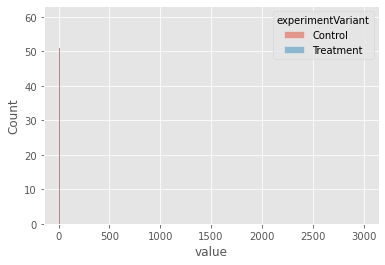

In [10]:
sns.histplot(data=df, x='value', hue='experimentVariant')
None

In [11]:
### Посмотрим на распределение без последних 5 наблдюдений, значения которых >= 1000

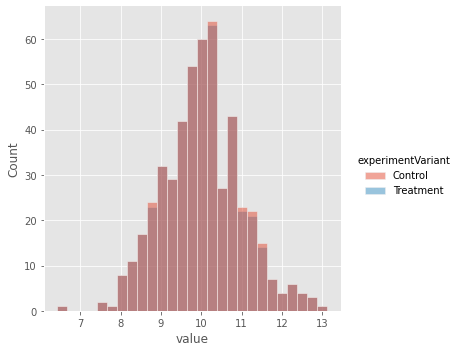

In [12]:
sns.displot(data=df.query('value < 1000'), x='value', hue='experimentVariant')
None

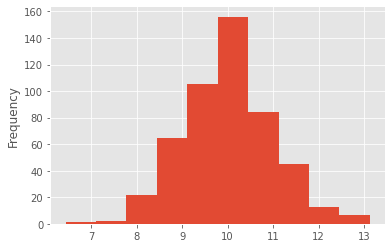

In [18]:
# Значения контрольной группы 
df.query('experimentVariant == "Control" & value < 1000')['value'].plot.hist()
None

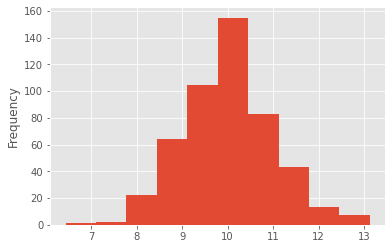

In [19]:
# Значения группы 'Тестовой'
df.query('experimentVariant == "Treatment" & value < 1000')['value'].plot.hist()
None

In [19]:
### Распределение похоже на нормальное 

### 1.2 Использование бутстрапа

In [ ]:
###

In [143]:
Control_df = df.query('experimentVariant == "Control"' )

In [144]:
Treatment_df = df.query('experimentVariant == "Treatment"' )

In [192]:
### Функция создания выборки 

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return boot_data

In [193]:
### Функция получения p_value
def get_p_value(boot_data):
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    return {"p_value": p_value}

In [210]:

def dov_interval(boot_data, bootstrap_conf_level = 0.95):
    
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    return ci


#### 1.2.1 Применение бутстрап (с np.mean) и критерия mann-whitney. Сравнение p-value

In [209]:
# Нулевая гипотеза - среднии в двух группах не различаются 

##### 1) Бутстрап

  0%|          | 0/1000 [00:00<?, ?it/s]

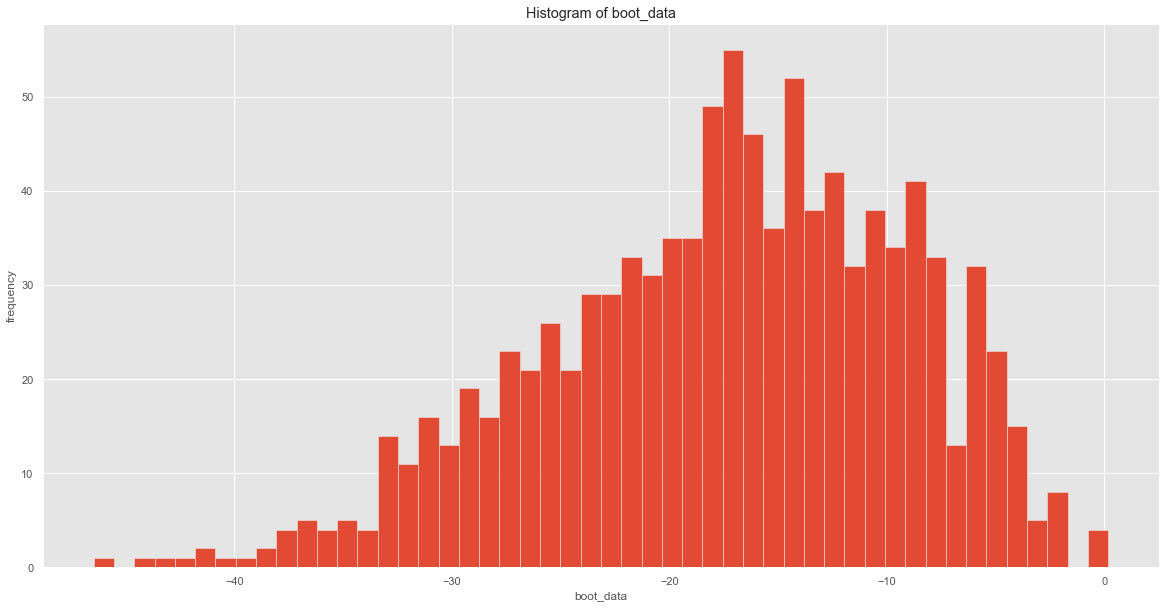

In [212]:
boot_data = get_bootstrap(Control_df['value'], Treatment_df['value'], statistic=np.mean)


In [213]:
dov_interval(boot_data)

,0
0.025,-34.78465
0.975,-4.07405


In [197]:
get_p_value(boot_data)

{'p_value': 0.03967566686194799}

In [214]:
# Отклоняем 0 гипотезу, так как средние статистически различаются (p-value < 0.05).
# Так же 0 не входит в дов. интервал. Уровень значимости = 0.05

##### 2) mann-whitney

In [198]:
mannwhitneyu(Control_df['value'], Treatment_df['value'])

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

#### 1.2.2 Применение бутстрап (с np.median) и критерия mann-whitney. Сравнение p-value

##### 1) Бутстрап

  0%|          | 0/1000 [00:00<?, ?it/s]

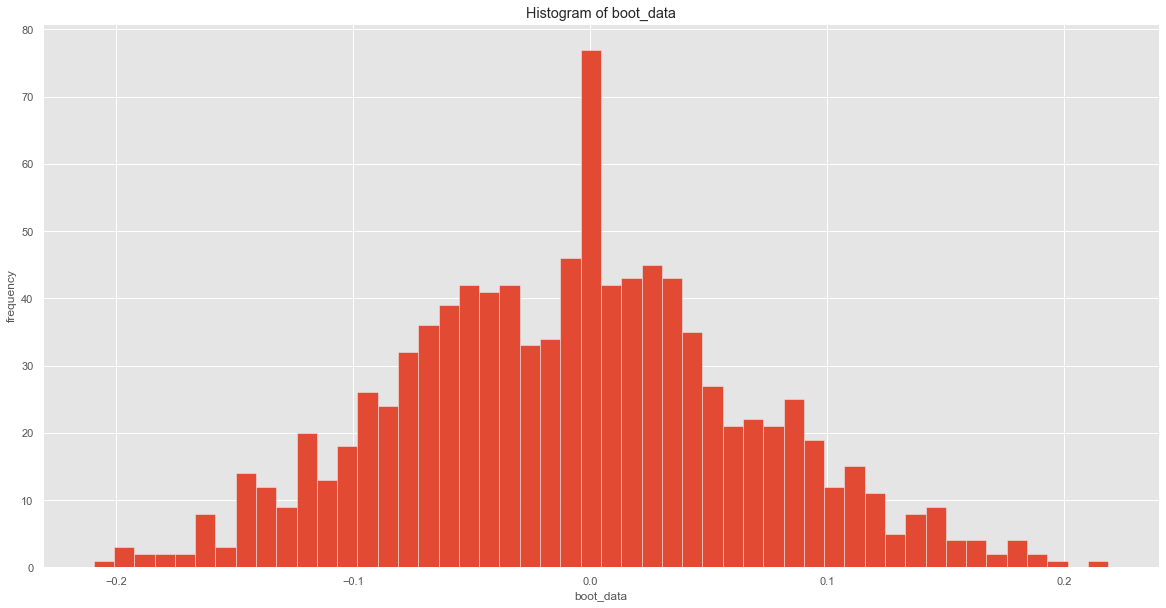

In [206]:
boot_data = get_bootstrap(Control_df['value'], Treatment_df['value'], statistic=np.median)

In [207]:
dov_interval(boot_data)

,0
0.025,-0.147227
0.975,0.142210


In [208]:
get_p_value(boot_data)

{'p_value': 0.9176545797670453}

##### 2) mann-whitney

In [201]:
mannwhitneyu(Control_df['value'], Treatment_df['value'])

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

In [215]:
# Отклоняем альтернативную гипотезу, так как средние статистически  не различаются (p-value > 0.05).
# Так же 0  входит в дов. интервал. Уровень значимости = 0.05

## Вывод: 
## 1)Исходя из проведенного исследования, учитывая тот факт, что в выборке присутствуют выбросы - медиана является лучшей статистикой для проверки различий между группами, так как она нейтральна к выбросам ( Используется ранговый подход к расчету значения).
## 2) Помимо этого, был проведет тест mann-whitney, который показал отсуствие различий между выборками. Этот тест так же использует ранговых подход к расчету значений 
## 3) Перед проведением какого-либо теста, нужно понять, с каким распределением имеем дело, есть ли выбросы. И исходя из этого, нужно выбирать оптимальный способ проведения стат. исследдования. Иначе, можно найти различия там, где их нет